In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import h5py
import subprocess
pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
            "#D0BBFF", "#FFFEA3", "#B0E0E6"]

nsteps = 200

In [2]:
# this function samples an initial condition vector runs simulation
def run_instance(m0, cov0, filename):
    x = np.random.multivariate_normal(m0, cov0)
    h5f = h5py.File('x0.hdf5', 'w')
    h5f.create_dataset('vector', data=x)
    h5f.close()
    command = ['./power', '--x0', '-o', filename]
    p = subprocess.Popen(command).wait()
    
def run_ad(m0):
    h5f = h5py.File('x0.hdf5', 'w')
    h5f.create_dataset('vector', data=m0)
    h5f.close()
    command = ['./power', '--x0', '-m']
    p = subprocess.Popen(command).wait()
    
# return the mean and the autocovariance for a single variable
def ad_query_var(nsteps, var_id):
    h5file = h5py.File('solution.hdf5','r')
    traj_mat = h5file.get('matrix')
    traj = np.array(traj_mat).reshape(traj_mat.shape[0]*traj_mat.shape[1])
    traj = traj.reshape(traj_mat.shape[0], traj_mat.shape[1], order = 'F')
    h5file.close()
    
    ad_mean = traj[var_id, :]
    ad_cov = np.zeros(nsteps)
    
    for i in range(nsteps):
        cov_file = "output/covSTEP" + str(i) + ".hdf5"
        h5file = h5py.File(cov_file,'r')
        traj_mat = h5file.get('matrix')
        traj = np.array(traj_mat).reshape(traj_mat.shape[0]*traj_mat.shape[1])
        traj = traj.reshape(traj_mat.shape[0], traj_mat.shape[1], order = 'F')
        h5file.close() 
        ad_cov[i] = traj[var_id, var_id]
    
    return ad_mean, ad_cov

In [3]:
# read mean vector and create covariance matrix
h5file = h5py.File('input/m0_9bus.hdf5','r')
m0_vec = h5file.get('vector')
m0 = np.array(m0_vec)
m0[4] = -0.005

diag_cov = 0.0000001*np.ones(len(m0))
diag_cov[4] = 0.000001
cov0 = np.diag(diag_cov)
h5file.close()

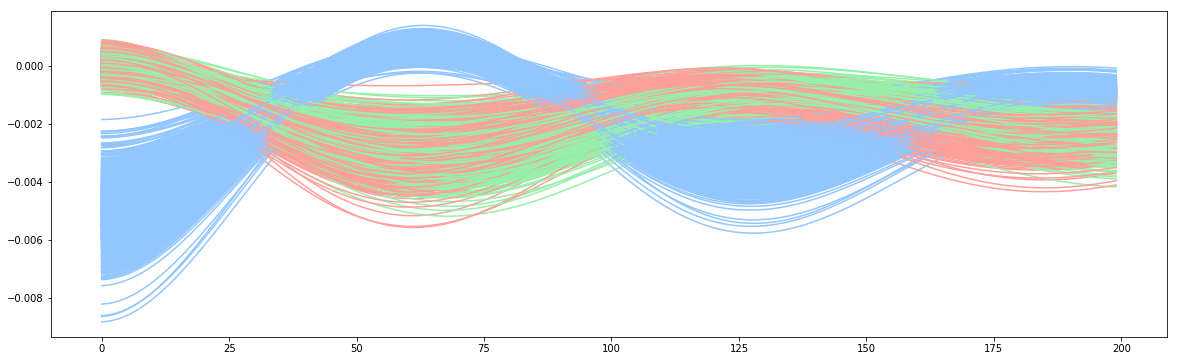

In [4]:
plt.figure(figsize=(20,6))

nsamp = 1000

store_traj = np.zeros((nsamp, nsteps))

for i in range(nsamp):
    filename = 'output/' + str(i) + '.hdf5'
    run_instance(m0, cov0, filename)
    h5file = h5py.File(filename,'r')
    traj_mat = h5file.get('matrix')
    traj = np.array(traj_mat).reshape(traj_mat.shape[0]*traj_mat.shape[1])
    traj = traj.reshape(traj_mat.shape[0], traj_mat.shape[1], order = 'F')
    h5file.close()
    
    # plot
    plt.plot(traj[4,:], color = pastel[0])
    plt.plot(traj[4+10,:], color = pastel[1])
    plt.plot(traj[4+20,:], color = pastel[2])
    store_traj[i, :] = traj[4, :]

In [10]:
mc_mean = np.zeros(nsteps)
mc_cov = np.zeros(nsteps)

# Monte Carlo statistics
for i in range(nsteps):
    mc_mean[i] = np.mean(store_traj[:, i])
    mc_cov[i] = np.cov(store_traj[:, i])
    
# AD statistics
run_ad(m0)
ad_mean, ad_cov = ad_query_var(nsteps, 4)

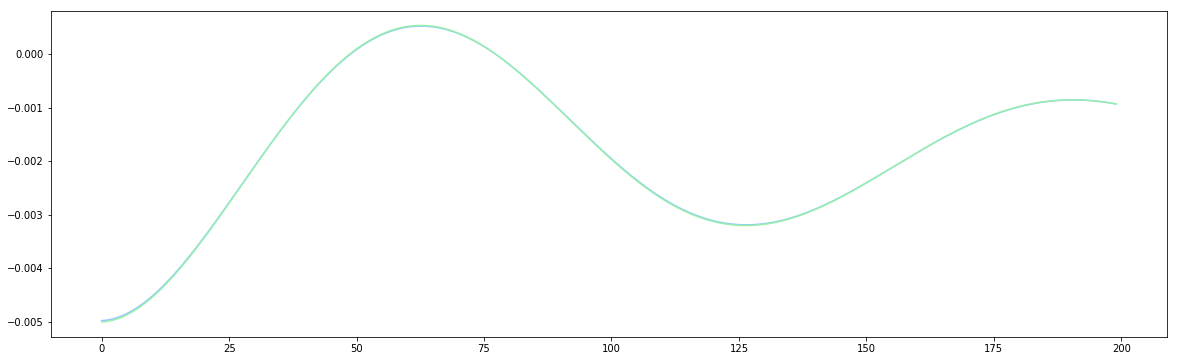

0.000151968541349


In [11]:
plt.figure(figsize=(20,6))
plt.plot(mc_mean, color = pastel[0])
plt.plot(ad_mean, color = pastel[1])
plt.show()
print(LA.norm(mc_mean - ad_mean))

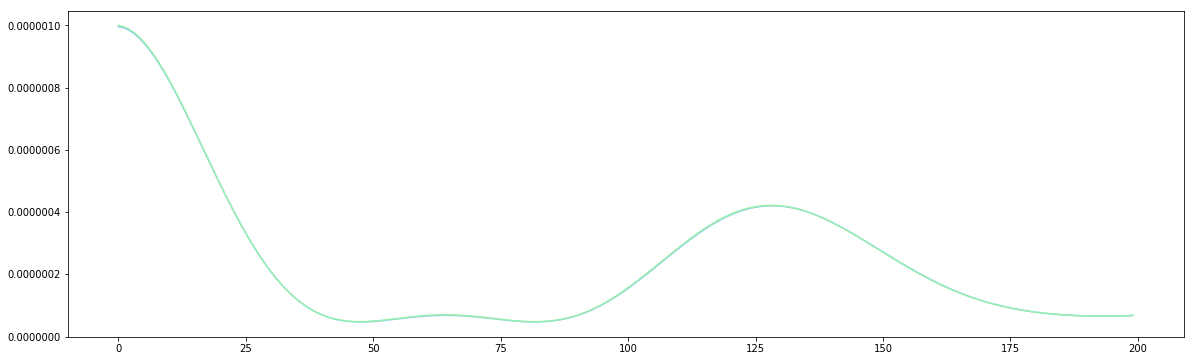

2.02327841777e-08


In [12]:
plt.figure(figsize=(20,6))
plt.plot(mc_cov, color = pastel[0])
plt.plot(ad_cov, color = pastel[1])
plt.show()
print(LA.norm(mc_cov - ad_cov))